# MS004 Preprocess
Created: 04/04/2024 \
Updated: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS004'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [38]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/raw/MS004_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2366079  =      0.000 ...  2310.624 secs...


In [39]:
mne_data

<RawEDF | MS004_SWB.edf, 148 x 2366080 (2310.6 s), ~2.61 GB, data loaded>

In [8]:
# mne_data.ch_names

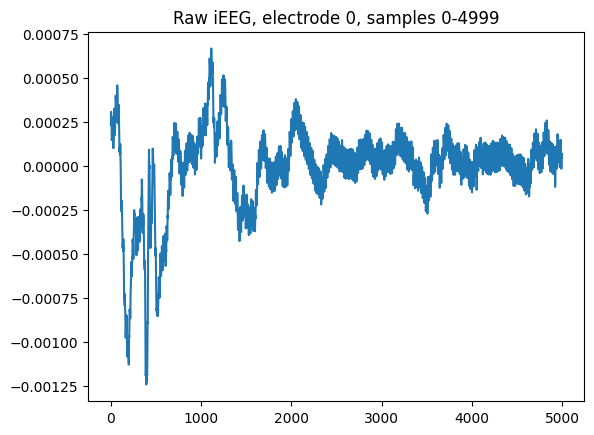

In [8]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Photodiode
- examine photodiode 

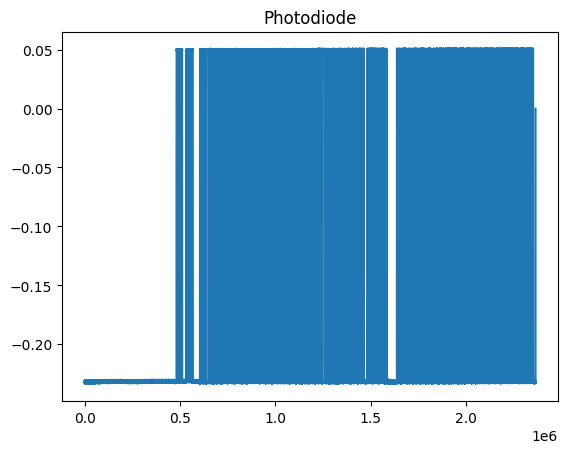

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [10]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/photodiode.fif
[done]


In [11]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS004_SWB.edf, 147 x 2366080 (2310.6 s), ~2.59 GB, data loaded>

### Resampling data 

In [40]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 148 out of 148 | elapsed:   18.1s finished


<RawEDF | MS004_SWB.edf, 148 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

### Notch filter line noise

In [41]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    5.2s finished


<RawEDF | MS004_SWB.edf, 148 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

### Anatomical Localization

In [42]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS004_SWB.edf, 148 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

In [43]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x      mni_y  \
0    LaCaS1    Unknown  -4.999780  32.998632   9.399995  -5.110147  20.313460   
1   LaCaS10     A8dl_L -19.799162  40.998299  51.399993 -21.380381  33.493736   
2    LaCaS2    Unknown  -6.999697  33.798599  13.799995  -7.451296  21.880915   
3    LaCaS3    Unknown  -8.599630  34.998549  18.599995  -9.401439  23.748520   
4    LaCaS4     A32p_L -10.199563  36.198499  22.999995 -11.236510  25.502741   
..      ...        ...        ...        ...        ...        ...        ...   
77   RmOlF5    Unknown  25.398950  35.798516  15.799995  28.472357  25.071580   
78   RmOlF6    Unknown  28.998799  35.798516  18.999995  32.166475  25.487460   
79   RmOlF7   A9/46v_R  32.998632  34.998549  21.399995  36.411860  24.897113   
80   RmOlF8     A8vl_R  36.998465  34.998549  24.199995  40.586243  25.242135   
81   RmOlF9     A8vl_R  40.598314  34.598566  26.999994  44.285109  25.171395   

        mni_z       gm                                 NMM     Anat  \
0   10.206352  Unknown              Left Lateral Ventricle  Unknown   
1   54.675622  Unknown     Left SFG superior frontal gyrus  Unknown   
2   14.764700    White          Left Cerebral White Matter  Unknown   
3   19.653786    White          Left Cerebral White Matter  Area 33   
4   24.173401    White  Left ACgG anterior cingulate gyrus  Unknown   
..        ...      ...                                 ...      ...   
77  17.516928    White         Right Cerebral White Matter  Unknown   
78  21.130085    White         Right Cerebral White Matter  Unknown   
79  24.029039     Gray      Right MFG middle frontal gyrus  Unknown   
80  27.382506     Gray      Right MFG middle frontal gyrus  Unknown   
81  30.762863     Gray         Right Cerebral White Matter  Unknown   

                   AnatMacro    BN246                            YBA_1  \
0                    Unknown  Unknown                          Unknown   
1   L Superior Frontal Gyrus    L SFG  Left superior frontal gyrus 4 D   
2                    Unknown  Unknown                          Unknown   
3                    Unknown  Unknown                          Unknown   
4                    Unknown     L CG           Left cingulate gyrus H   
..                       ...      ...                              ...   
77                   Unknown  Unknown                          Unknown   
78    R Middle Frontal Gyrus  Unknown                          Unknown   
79    R IFG (p Triangularis)    R MFG   Right middle frontal gyrus 4 B   
80    R IFG (p Triangularis)    R MFG                          Unknown   
81    R IFG (p Triangularis)    R MFG   Right middle frontal gyrus 4 C   

           ManualExamination Notes  
0     Left cingulate gyrus H   NaN  
1                        OOB   NaN  
2                         WM   NaN  
3                         WM   NaN  
4                         WM   NaN  
..                       ...   ...  
77                        WM   NaN  
78                        WM   NaN  
79                       NaN   NaN  
80  Right middle frontal 4 B   NaN  
81                       NaN   NaN  

[82 rows x 16 columns]

In [44]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'uLmOlF',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'pLesHM1',
 'pLesHM2',
 'pLesHM3',
 'pLesHM4',
 'pLesHM5',
 'pLesHM6',
 'pLesHM7',
 'pLesHM8',
 'RaCaS1',
 'RaCaS10',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RHplT1',
 'RHplT10',
 'RHplT2',
 'RHplT3',
 'RHplT4',
 'RHplT5',
 'RHplT6',
 'RHplT7',
 'RHplT8',
 'RHplT9',
 'RLes21',
 'RLes22',
 'RLes23',
 'RLes24',
 'RLes25',
 'RLes26',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'uRmOlF',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9']

In [45]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['alespm1', 'alespm2', 'alespm3', 'alespm4', 'alespm5', 'alespm6', 'alespm7', 'alespm8', 'lespm1', 'lespm2', 'lespm3', 'lespm4', 'lespm5', 'lespm6', 'lespm7', 'lespm8', 'lespm9', 'lespm10', 'llespm1', 'llespm2', 'llespm3', 'llespm4', 'llespm5', 'llespm6', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', '02', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c126', 'c127', 'c128', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [46]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [47]:
unmatched_seeg #make sure there are no unmatched names


[]

In [48]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [49]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'rmcms1': 'rmcms1',
 'rmcms2': 'rmcms2',
 'rmcms3': 'rmcms3',
 'rmcms4': 'rmcms4',
 'rmcms5': 'rmcms5',
 'rmcms6': 'rmcms6',
 'rmcms7': 'rmcms7',
 'rmcms8': 'rmcms8',
 'alespm1': 'alespm1',
 'alesp

In [50]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS004_SWB.edf, 148 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

In [51]:
# right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
# left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
# print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
# print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 45 left sEEG and 43 right sEEG electrodes
We have a total of 88 sEEG electrodes


In [58]:
# this subject has ch that start with a or p(ugh)
real_ch = mne_data.ch_names[:104] # 104 confirmed manually 
drop_ch =  mne_data.ch_names[105:]
drop_ch

['f7',
 't3',
 't5',
 'o1',
 'f3',
 'c3',
 'p3',
 'fp2',
 'f8',
 't4',
 't6',
 '02',
 'f4',
 'c4',
 'p4',
 'fz',
 'cz',
 'pz',
 'ekg1',
 'ekg2',
 'c126',
 'c127',
 'c128',
 'dc1',
 'dc2',
 'dc3',
 'dc4',
 'dc5',
 'dc6',
 'dc7',
 'dc8',
 'dc9',
 'dc10',
 'dc11',
 'dc12',
 'dc13',
 'dc14',
 'dc15',
 'dc16',
 'trig',
 'osat',
 'pr',
 'pleth']

In [60]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in real_ch}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS004_SWB.edf, 148 x 1155312 (2310.6 s), ~1.27 GB, data loaded>

In [61]:
mne_data.drop_channels(drop_ch) #number of chans should = number of seegs 

<RawEDF | MS004_SWB.edf, 105 x 1155312 (2310.6 s), ~925.6 MB, data loaded>

In [62]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS004_SWB.edf, 105 x 1155312 (2310.6 s), ~925.6 MB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [63]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [64]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [65]:
probe_ch_counts

{'lacas': 10,
 'lhplt': 10,
 'lmolf': 9,
 'pleshm': 8,
 'racas': 10,
 'rhplt': 10,
 'rles': 6,
 'rmcms': 8,
 'rmolf': 9,
 'ulmolf': 1,
 'urmolf': 1}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [30]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)

['lacas1', 'lacas2', 'lespm1', 'lespm8', 'lespm9', 'rmcms5', 'rmcms6']

<IPython.core.display.Javascript object>


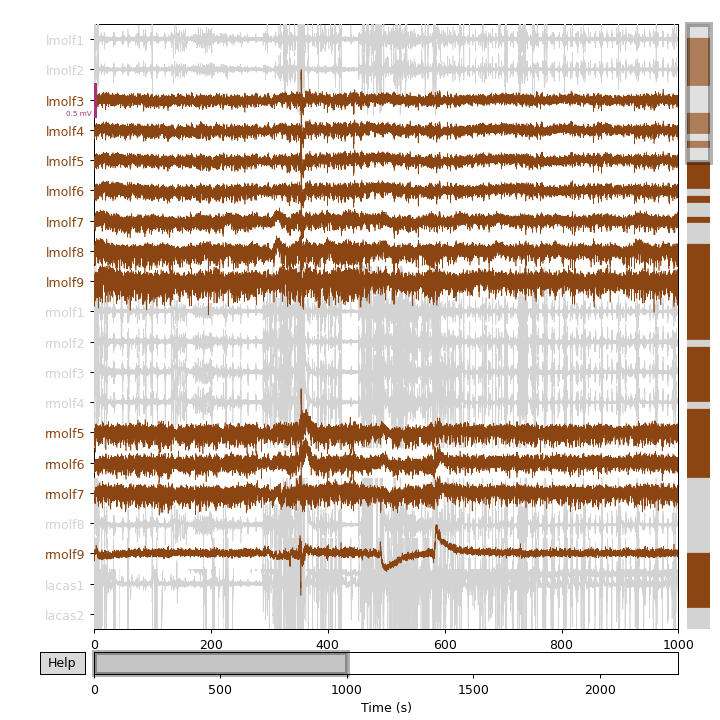

In [30]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=20, scalings=mne_data._data.max()/50)


In [66]:
mne_data.info['bads'] = ['lmolf1',
 'lmolf2',
 'rmolf1',
 'rmolf2',
 'rmolf3',
 'rmolf4',
 'rmolf8',
 'lacas2',
 'lacas1',
 'lacas7',
 'lacas9',
 'lacas10',
 'racas2',
 'racas3',
 'racas4',
 'lespm1',
 'lespm10',
 'rles26',
 'lhplt1',
 'rles25',
 'lhplt2',
 'lhplt3',
 'lhplt4',
 'lhplt5',
 'lhplt6',
 'lhplt7',
 'lhplt8',
 'lhplt9',
 'rhplt8',
 'rhplt9',
 'rhplt10']

mne_data.info['bads']

['lmolf1',
 'lmolf2',
 'rmolf1',
 'rmolf2',
 'rmolf3',
 'rmolf4',
 'rmolf8',
 'lacas2',
 'lacas1',
 'lacas7',
 'lacas9',
 'lacas10',
 'racas2',
 'racas3',
 'racas4',
 'lespm1',
 'lespm10',
 'rles26',
 'lhplt1',
 'rles25',
 'lhplt2',
 'lhplt3',
 'lhplt4',
 'lhplt5',
 'lhplt6',
 'lhplt7',
 'lhplt8',
 'lhplt9',
 'rhplt8',
 'rhplt9',
 'rhplt10']

In [67]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 31 items (lmolf1, lmolf2, rmolf1, rmolf2, rmolf3, rmolf4, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 104 sEEG, 1 EEG
 custom_ref_applied: False
 dig: 80 items (80 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 16:18:43 UTC
 nchan: 105
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [69]:
#run if only re-ref
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [70]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is greater than the number of electrodes in the localization file
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=17, n_times=1155312
    Range : 0 ... 1155311 =      0.000 ...  2310.622 secs
Ready.
Added the following bipolar channels:
lacas6-lacas8, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, pleshm1-pleshm2, racas5-racas6, racas8-racas9, rhplt1-rhplt2, rles22-rles23, rles23-rles24, rmcms1-rmcms2, rmcms2-rmcms3, rmcms3-rmcms4, rmcms4-rmcms5, rmolf6-rmolf7, rmolf7-rmolf9


In [71]:
mne_data_bp_reref

<RawEDF | MS004_SWB.edf, 17 x 1155312 (2310.6 s), ~149.9 MB, data loaded>

In [72]:
mne_data_bp_reref.ch_names

['lacas6-lacas8',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'pleshm1-pleshm2',
 'racas5-racas6',
 'racas8-racas9',
 'rhplt1-rhplt2',
 'rles22-rles23',
 'rles23-rles24',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms3-rmcms4',
 'rmcms4-rmcms5',
 'rmolf6-rmolf7',
 'rmolf7-rmolf9']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


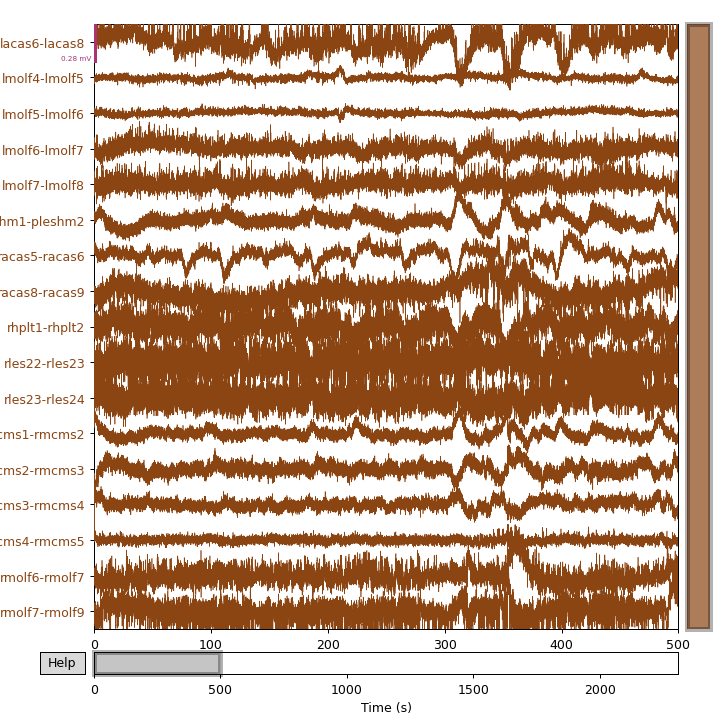

<IPython.core.display.Javascript object>


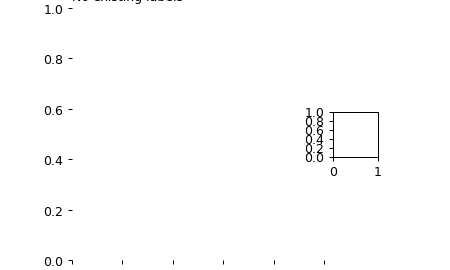

IndexError: list index out of range

In [73]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max()/5)
fig.fake_keypress('a')

Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


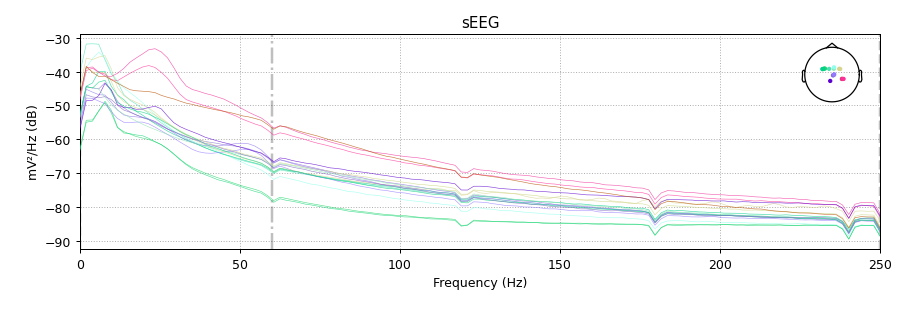

<IPython.core.display.Javascript object>


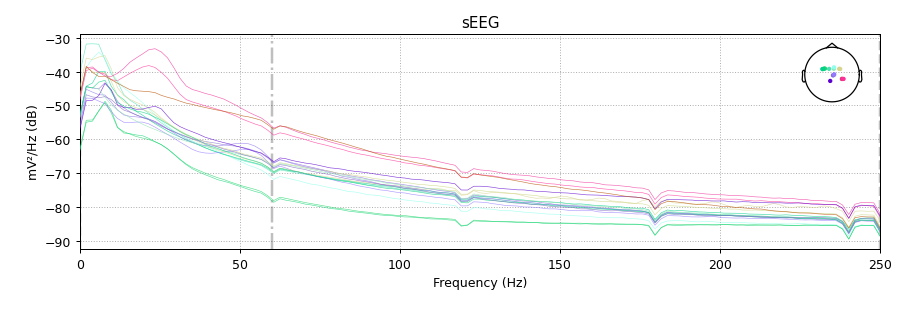

In [74]:
mne_data_bp_reref.compute_psd().plot()

In [75]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/bp_ref_ieeg.fif
[done]


## Save mne_data

In [76]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [77]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [78]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/photodiode.fif...
Isotrak not found
    Range : 0 ... 2366079 =      0.000 ...  2310.624 secs
Ready.
Reading 0 ... 2366079  =      0.000 ...  2310.624 secs...


In [110]:
photodiode_data

<Raw | photodiode.fif, 1 x 2366080 (2310.6 s), ~18.1 MB, data loaded>

In [79]:
#resampling if patient is not sampled at 512
resample_sr = 500
photodiode_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished


<Raw | photodiode.fif, 1 x 1155312 (2310.6 s), ~8.8 MB, data loaded>

In [80]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 157 pulses


In [81]:
print(slope, offset,smoothSize,windSize,height)

0.9999917699032468 -4.043263779094104 11 15 0.7


In [82]:
#### verify photodiode alignment
    # requires newer functions from new sync utils package (older version used here)

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


# # moving_average
# neural_ts = get_neural_ts_photodiode(temp_diode, smoothSize=15, height=0.7)
# neural_ts.shape

# pulses = [(x*slope + offset) for x in beh_ts]
# plt.plot(neural_ts,'o')
# # plt.plot(pulses,'o')
# plt.show()

# plt.plot(scipy.stats.zscore(temp_diode._data[0,:]))
# # plt.plot(pulses)
# plt.plot(np.array(pulses)*1024, 
#          np.ones_like(np.array(pulses)*1024)-0.5, '.')
# # plt.plot(neural_ts*1024, 
# #          np.ones_like(neural_ts)-0.25, '.')
# plt.xlim([1900000,2200000])
# plt.show()

# temp_diode = photodiode_data.copy()
# temp_diode._data[0,0:1000000] = np.min(temp_diode._data[0,:])
# temp_diode._data[0,3000000:] = np.min(temp_diode._data[0,:])

In [83]:
pulses = [(x*slope + offset) for x in beh_ts]

In [84]:
# moving_average
neural_ts = get_neural_ts_photodiode(photodiode_data, smoothSize=15, height=0.7)
neural_ts.shape

(157,)

<IPython.core.display.Javascript object>


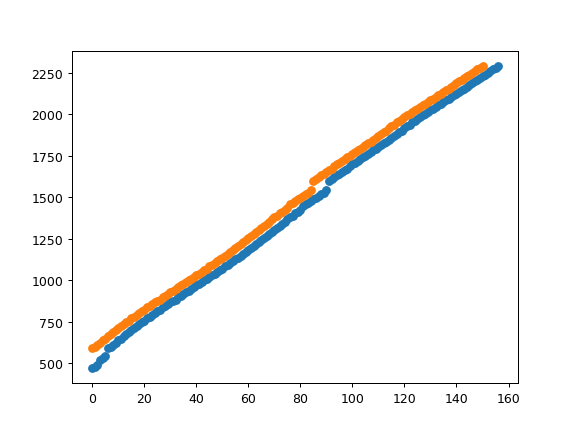

In [85]:
plt.plot(neural_ts,'o')
plt.plot(pulses,'o')
plt.show()

<IPython.core.display.Javascript object>


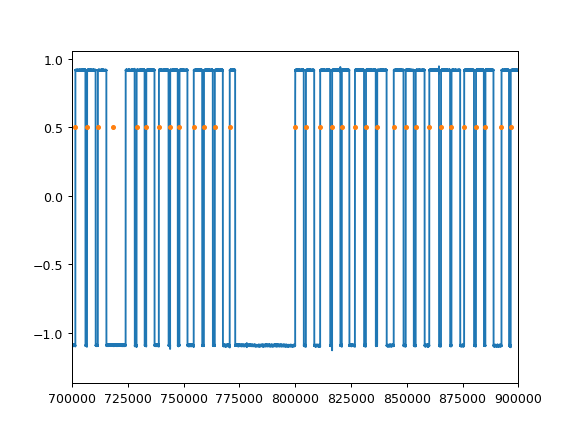

In [89]:
plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*500, 
         np.ones_like(np.array(pulses)*500)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([700000,900000])
plt.show()

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [115]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [116]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [117]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [118]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/bp_ref_ieeg.fif...
    Range : 0 ... 1155311 =      0.000 ...  2310.622 secs
Ready.
Reading 0 ... 1155311  =      0.000 ...  2310.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.2s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 16 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS004/bp_ref_ieeg.fif...
    Range : 0 ... 1155311 =      0.000 ...  2310.622 secs
Ready.
Reading 0 ... 1155311  =      0.000 ...  2310.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.9s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 16 columns


In [119]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~27.5 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~64.2 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [120]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']

In [121]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 38 columns
Replacing existing metadata with 38 columns


In [122]:
epochs_all_evs[event].metadata

lacas6-lacas8 lmolf4-lmolf5 lmolf5-lmolf6 lmolf6-lmolf7 lmolf7-lmolf8  \
0             NaN           NaN           NaN           NaN           NaN   
1             NaN           NaN           NaN           NaN           NaN   
2             NaN           NaN           NaN           NaN           NaN   
3             NaN           NaN           NaN           NaN           NaN   
4             NaN           NaN           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
145           NaN         noise           NaN           NaN           NaN   
146           NaN           NaN           NaN           NaN           NaN   
147           NaN           NaN           NaN           NaN           NaN   
148           NaN           NaN           NaN           NaN           NaN   
149           NaN           NaN           NaN           NaN           NaN   

    racas5-racas6 racas8-racas9 rhplt1-rhplt2 rles22-rles23 rles23-rles24  \
0             NaN           NaN           NaN           NaN           NaN   
1             NaN           NaN           NaN           NaN           NaN   
2             NaN           NaN           NaN           NaN           NaN   
3             NaN           NaN           NaN           NaN           NaN   
4             NaN           NaN           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
145           NaN           NaN           NaN           NaN           NaN   
146           NaN           NaN           NaN           NaN           NaN   
147           NaN           NaN           NaN           NaN           NaN   
148           NaN           NaN           NaN           NaN           NaN   
149           NaN           NaN           NaN           NaN           NaN   

     ... totalCPE decisionCPE totalRegret decisionRegret totalRelief  \
0    ...     0.67        0.37        0.00           0.00        0.67   
1    ...    -1.40       -0.90       -1.40          -0.90        0.00   
2    ...     0.36        0.20        0.00           0.00        0.36   
3    ...    -0.55       -0.30       -0.55          -0.30        0.00   
4    ...    -1.12       -0.80       -1.12          -0.80        0.00   
..   ...      ...         ...         ...            ...         ...   
145  ...     0.44        0.24        0.00           0.00        0.44   
146  ...     1.56        1.56        0.00           0.00        1.56   
147  ...     1.08        0.78        0.00           0.00        1.08   
148  ...    -0.15       -0.15       -0.15          -0.15        0.00   
149  ...    -1.50       -1.50       -1.50          -1.50        0.00   

    decisionRelief totalCF  decisionCF   pRPE   nRPE  
0             0.37    0.00        0.30  0.335  0.000  
1             0.00    0.00       -0.50  0.000 -0.700  
2             0.20   -0.36       -0.20  0.180  0.000  
3             0.00    0.25        0.00  0.000 -0.275  
4             0.00    0.32        0.00  0.000 -0.560  
..             ...     ...         ...    ...    ...  
145           0.24    0.00        0.20  0.220  0.000  
146           1.56   -2.16       -2.16  0.000  0.000  
147           0.78    0.00        0.30  0.540  0.000  
148           0.00    0.15        0.15  0.000  0.000  
149           0.00    1.50        1.50  0.000  0.000  

[150 rows x 38 columns]

### Save raw epoched data 

In [123]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [124]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [125]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [126]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [127]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]


temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [128]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 16, ~275.3 MB>}

In [129]:
power_epochs = {}

In [130]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


Not setting metadata
Adding metadata with 38 columns


In [131]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 16, ~1.34 GB>}

In [132]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [133]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)


04052024


In [69]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

-4.039888709769912


<IPython.core.display.Javascript object>


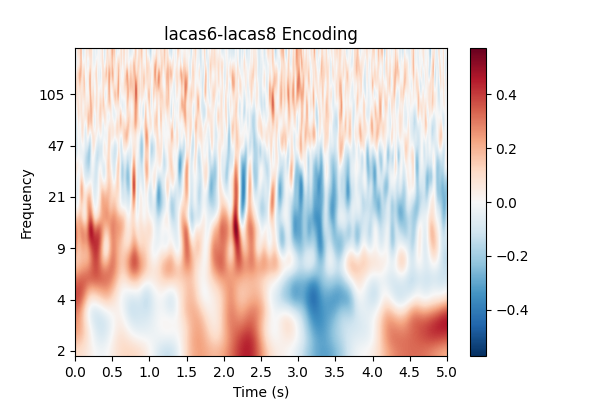

<IPython.core.display.Javascript object>


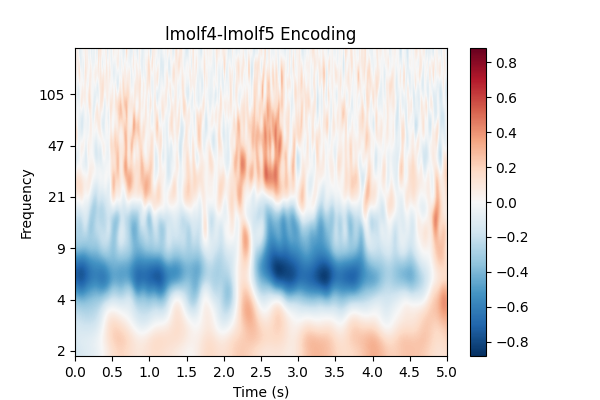

<IPython.core.display.Javascript object>


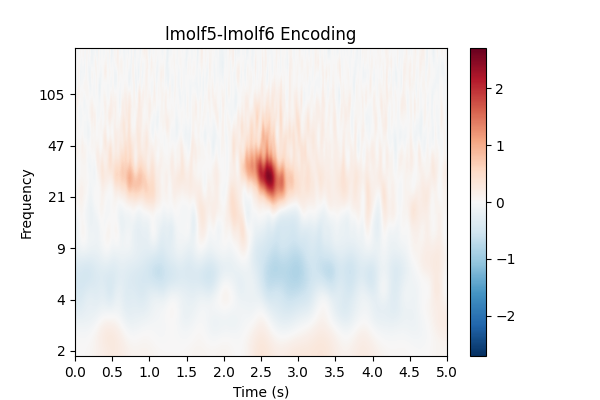

<IPython.core.display.Javascript object>


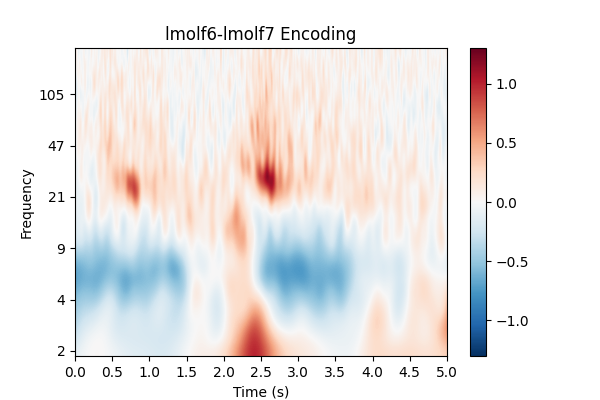

<IPython.core.display.Javascript object>


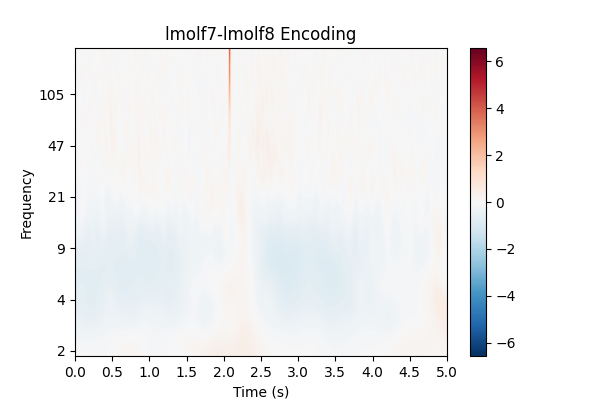

<IPython.core.display.Javascript object>


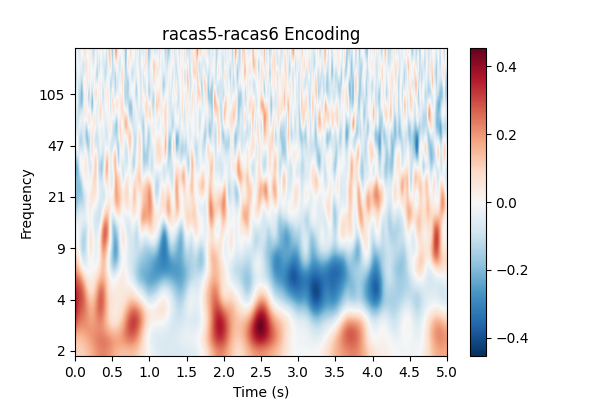

<IPython.core.display.Javascript object>


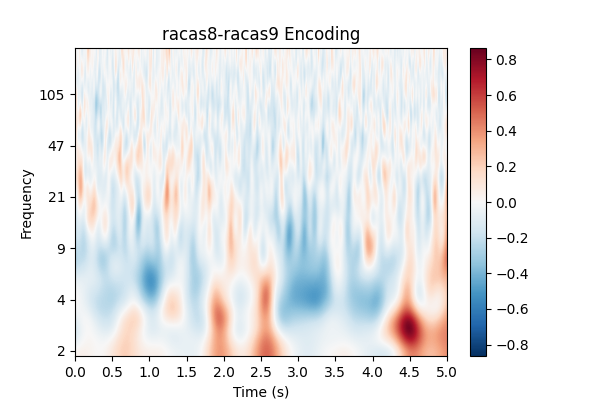

<IPython.core.display.Javascript object>


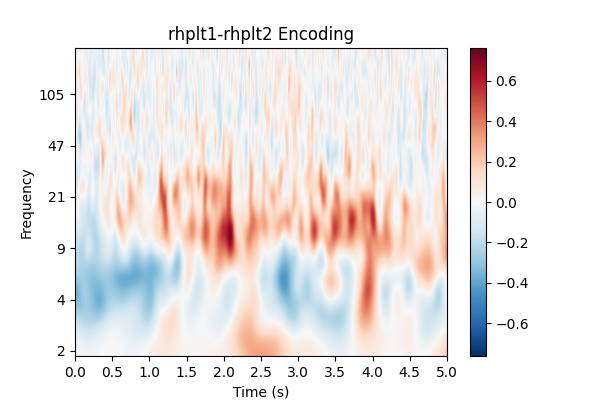

<IPython.core.display.Javascript object>


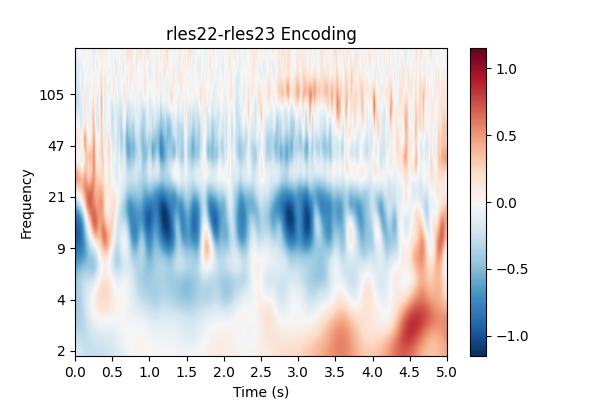

<IPython.core.display.Javascript object>


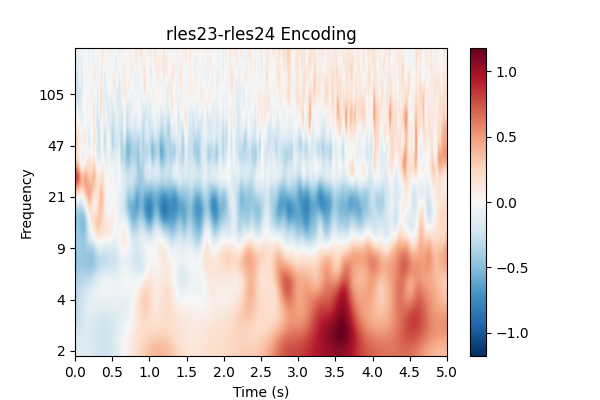

<IPython.core.display.Javascript object>


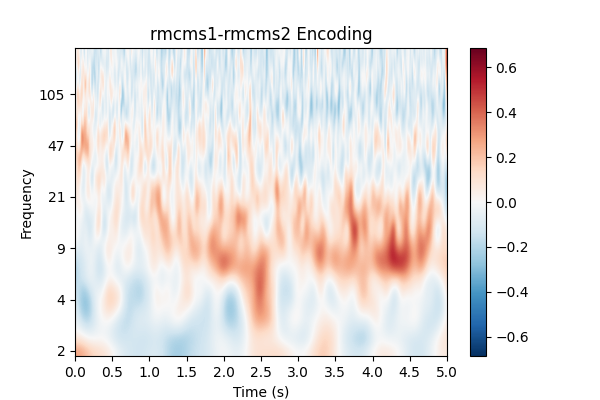

<IPython.core.display.Javascript object>


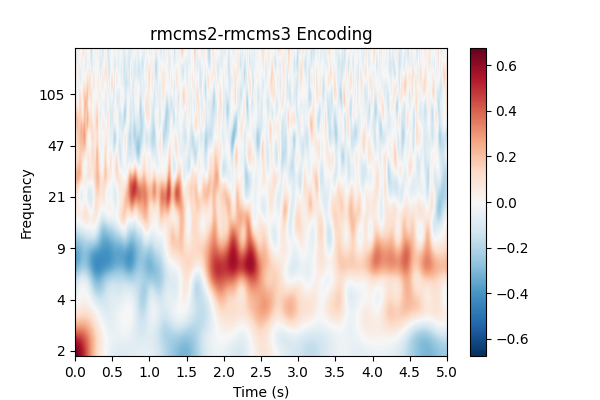

<IPython.core.display.Javascript object>


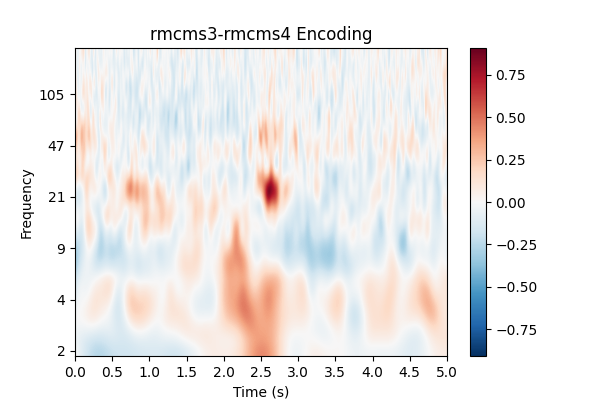

<IPython.core.display.Javascript object>


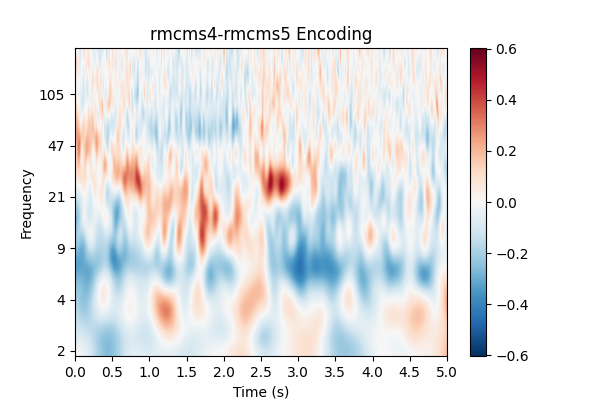

<IPython.core.display.Javascript object>


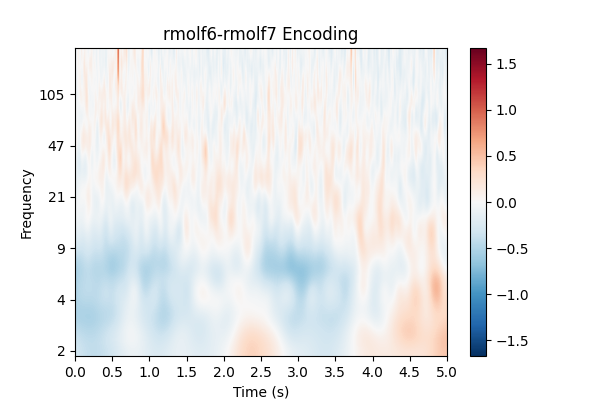

<IPython.core.display.Javascript object>


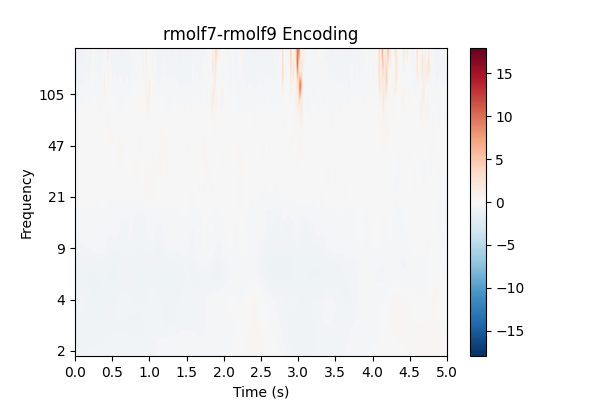

In [134]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()
